**(Run this cell to define useful Latex macros)**
\\[
\newcommand{\card}[1]{\left\lvert#1\right\rvert}
\newcommand{\condbar}[0]{\,\big|\,}
\newcommand{\eprob}[1]{\widehat{\text{Pr}}\left[#1\right]}
\newcommand{\fpartial}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ffpartial}[2]{\frac{\partial^2 #1}{\partial {#2}^2}}
\newcommand{\gradient}[0]{\nabla}
\newcommand{\norm}[1]{\left\lvert\left\lvert#1\right\rvert\right\rvert}
\newcommand{\prob}[1]{\text{Pr}\left[#1\right]}
\newcommand{\pprob}[2]{\text{Pr}_{#1}\left[#2\right]}
\newcommand{\set}[1]{\left\{#1\right\}}
\newcommand{\trans}[1]{#1^\mathsf{T}}
\\]

## Lecture 02: Neural Networks

Logistic regression is a form of *linear classification* model. A linear classifier has a linear *decision boundary*. It is probably easiest to explain with an example:

\\[
z(x) = 3 + 5x_1 - 4x_2
\\
f(x) = \sigma(z(x))
\\]

Let's first graph the logistic function as a function of the value of $z$. We'll disregard the $x$.

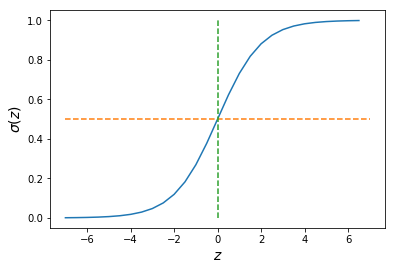

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x_values = np.arange(-7, 7, 0.5)
y_values = 1 / (1 + np.exp(-x_values))

plt.plot(x_values, y_values, '-')
plt.plot([-7, 7], [0.5, 0.5], '--')
plt.plot([0, 0], [0.0, 1.0], '--')
plt.ylabel('$\sigma(z)$', fontsize = 14)
plt.xlabel('$z$', fontsize = 14)


The way the sigmoid function works is $\sigma(z) = \frac{e^z}{1 + e^z}$. Notice that (a) $\sigma(z) = 0.5$ when $z = 0$, (b) $\sigma(z) < 0.5$ when $z < 0$, and (c) $\sigma(z) > 0.5$ when $z > 0$.

When we consider $z$ as a function of $x$, we see that our model classifies $(x_1, x_2)$ as a positive example when $3 + 5x_1 - 4x_2 > 0$. When this is $< 0$, we classify $(x_1, x_2)$ as negative. What is the *boundary* between these two spaces? What are the points where we think it is equally likely that $(x_1, x_2)$ is a positive or negative example? This is when $z(x) = 0$. We can solve for these $x$ values:

\\[
\begin{align}
3 + 5x_1 - 4x_2 &= 0
\\
x_2 = \frac{5}{4}x_1 + \frac{3}{4}
\end{align}
\\]

Let's graph this line to check it out:


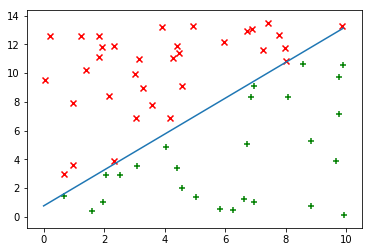

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x_values = np.arange(0, 10, 0.1)
y_values = (5/4) * x_values + 3/4
plt.plot(x_values, y_values, '-')

random_x1s = np.random.uniform(size = 60) * 10
random_x2s = np.random.uniform(size = 60) * 14
classified_positive = ((5/4) * random_x1s + 3/4) > random_x2s
classified_negative = np.logical_not(classified_positive)

plt.scatter(random_x1s[classified_positive], random_x2s[classified_positive], marker = '+', color = 'green')
plt.scatter(random_x1s[classified_negative], random_x2s[classified_negative], marker = 'x', color = 'red')


Not every classification problem can be modeled well with a linear decision boundary. Consider the following problem:

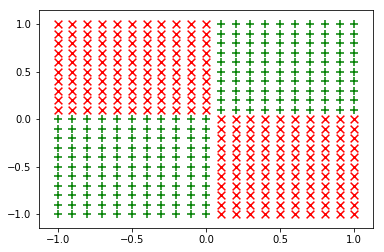

In [3]:
x1s = []
x2s = []
for x1 in np.arange(-1, 1.1, 0.1):
    for x2 in np.arange(-1, 1.1, 0.1):
        x1s.append(x1)
        x2s.append(x2)
x1s = np.array(x1s)
x2s = np.array(x2s)

is_positive = x1s * x2s > 0
is_negative = np.logical_not(is_positive)

plt.scatter(
    x1s[is_positive],
    x2s[is_positive],
    marker = '+',
    color = 'green',
    s = 60
)
plt.scatter(
    x1s[is_negative],
    x2s[is_negative],
    marker = 'x',
    color = 'red',
    s = 60
)


That is: the positive examples occur when $x_1$ and $x_2$ have the same sign. The negative examples are those where $x_1$ and $x_2$ have opposite signs. No linear classifier can separate the positives and the negatives.

When could such a silly example like this actually happen in practice? Let's say I have two lightswitches for the lights in my room. I want to predict whether the lights are on based on the position of the switch.

If both switches are down, the lights are off. If one is up and the other is down, then the lights are on. If they are both flipped up, then the effect cancels and the lights are off again.

If I were trying to predict whether the lights are on from position of the switches, no linear classifier could do this effectively.

Why? The reason is that the *effect* or meaning of "switch 2 is in the up position" changes based on whether "switch 1 is in the down position" versus "in the up position."

Linear models always assume constant effect. In our example $f(x) = \sigma(3 + 5x_1 - 4x_2)$, the impact of $x_1$ is always the same: add 5 to the $z$ value. It doesn't matter what the value of $x_2$ is.


There are many ways to try to address this kind of problem. One is to extend the concept of a linear model and add in a bunch of "cross-terms" like $x_1 x_2$. That lets us capture two-variable interactions, but what about three-way interactions? What if we have three lightswitches in the room for a single lamp?

Even just adding the cross terms $x_i x_j$ causes an explosion in the number of variables and parameters. If there are $N$ $x$ dimensions, then if we add in synthetic $x_i x_j$ terms for every distinct pair $i, j$ we are adding $N(N-1)/2$ terms. That is a quadratic explosion in parameters to learn. If $N$ is one million (not particularly atypical), then $O(N^2)$ is about 1 *trillion*.

This is very computationally inefficient, but it also can cause massive overfitting. As you add in all these new dimensions, you're giving your model more and more ability to use this extra explanatory power to search for and find false relationships.

You want to give your model more power to capture complex relationships, but not go crazy and start seeing false relationships everywhere. There are ways to give the learner more explanatory power, and then *penalize* them for using it unnecesarily. This is called *regularization*. However, how do you know when to penalize a theory for being "unnecessary complex" without penalizing a "necessarily complex" theory? You don't.

The other problem is computational efficiency. If you increase the number of parameters hugely, you also increase the runtime hugely. The most relevant problem may be with *memory*. The best machine learning algorithms load an entire dataset into memory, and then compute, compute, compute. That way you load it from disk only once.

But if your dataset is too huge to fit in memory because you added trillions of new columns, you will have to page the dataset in and out of memory as you loop through it. This can be horribly inefficient.


A more efficient way than throwing in all possible interaction terms is to increase model complexity by *stacking* layers of logistic regressions in series. The output of a first layer logistic regression can be fed into the input of a second layer logistic regression. Series of logistic regressions can learn complex relationships as I'll show below. The input to the first layer is just the normal data input $x$.

Here's an example of a neural network. We'll look at it again later:

![](./images/02a_neural_net_diagram.jpg)

What makes this kind of model efficient is that the model can learn how the first layer should process the input data. That is, it can learn what interaction terms it should detect. This gives the model less additional *capacity* than just adding in interaction terms, but it is "configurable" capacity. This hits a sweet spot of efficiency and capacity.

Let's go through the model above. It solves the XOR problem. The first layer is:

\\[
\begin{align}
h_{1, 1} = f_{1, 1}(x_1, x_2) &= \sigma(1000 x_1)
\\
h_{1, 2} = f_{1, 2}(x_1, x_2) &= \sigma(1000 x_2)
\end{align}
\\]

This first pair of functions basically answers: is $x_1 > 0$, is $x_2 > 0$? If $x_1 > 0$, then $h_{1, 1}$ will tend to be very close to one, because $f_{1, 1}$ is very sensitive to $x_1$. I would say we are "soft binarizing" the input, because we are pushing the inputs extremely close to zero or to one.

I use the symbols $h_{1, 1}, h_{1, 2}$ to denote the outputs of these functions. These are called *hidden* values or *hidden outputs*. They are called hidden because they are neither the input, nor the final output. What they should be is unknown or "implicit" in the dataset. You see the $x$s and $y$s, but not the $h$s.

Next, let's feed in the hidden values to a next *layer*:

\\[
\begin{align}
h_{2, 1} = f_{2, 1}(h_{1, 1}, h_{1, 2}) &= \sigma\left(
    1000 \left(
        h_{1, 1} - h_{1, 2} - 0.5
    \right)
\right)
\\
h_{2, 2} = f_{2, 2}(h_{1, 1}, h_{1, 2}) &= \sigma\left(
    1000 \left(
        -h_{1, 1} + h_{1, 2} - 0.5
    \right)
\right)
\end{align}
\\]

If $h_1$ is close to zero, then $h_{2, 1}$ has no chance of being close to 1.0. But even if $h_1$ is close to one, we *still* need that $h_2$ is close to zero, else it will *cancel* out the effect of $h_1$. So $h_{2, 1}$ is close to one iff both $h_1$ is close to one AND $h_2$ is close to zero.

The situation for $h_{2, 2}$ is flipped. It is close to one iff $h_{1, 1}$ is close to zero and $h_2$ is close to one.

Finally, we may write:

\\[
\begin{align}
h_{3, 1} = f_{3, 1}(h_{2, 1}, h_{2, 2}) &= \sigma\left(
    1000 \left(
        h_{2, 1} + h_{2, 2} - 0.5
    \right)
\right)
\end{align}
\\]

This outputs one if $h_{2, 1}$ is close to one or $h_{2, 2}$ is close to one.

What we have built is a *network* of logistic regressions that emulates:

\\[
OR(AND(x_1, NOT(x_2)), AND(NOT(x_1, x_2)))
\\]


/Users/ruggeri/.anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


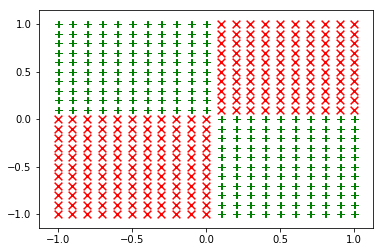

In [5]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

M = 1e3
def classify(x1, x2):
    # Classify is x1 > 0, is x2 > 0?
    h_1_1 = sigma(M * x1)
    h_1_2 = sigma(M * x2)
    
    # Classify is x1 > 0 AND is x2 < 0?
    h_2_1 = sigma(
        M * (h_1_1 - h_1_2 - 0.5)
    )
    # Classify is x1 < 0 AND x2 > 0?
    h_2_2 = sigma(
        M * (-h_1_1 + h_1_2 - 0.5)
    )

    # Classify does x1 != x2
    h_3_1 = sigma(
        M * (h_2_1 + h_2_2 - 0.5)
    )

    return h_3_1 > 0.5

x1s = []
x2s = []
for x1 in np.arange(-1, 1.1, 0.1):
    for x2 in np.arange(-1, 1.1, 0.1):
        x1s.append(x1)
        x2s.append(x2)
x1s = np.array(x1s)
x2s = np.array(x2s)

classified_positive = classify(x1s, x2s)
classified_negative = np.logical_not(classified_positive)

plt.scatter(
    x1s[classified_positive],
    x2s[classified_positive],
    marker = '$+$',
    color = 'green',
    s = 60
)
plt.scatter(
    x1s[classified_negative],
    x2s[classified_negative],
    marker = 'x',
    color = 'red',
    s = 60
)


What we are seeing here is that we an learn a much more sophisticated, nonlinear decision boundary if we have *layers* of logistic regressions, and with more than one logistic regression being performed at each layer.

This is exactly what a neural network is. It is just layers of logistic regressions.

![](./images/02a_neural_net_diagram.jpg)

In the above diagram, I have written constants like 1000 and 0.5 into the equations. I will now introduce some symbols to stand for those. Here are the first two layers of the network:

![](./images/02b_neural_net_matrices.jpg)

We call $W^{(1)}$ and $W^{(2)}$ *weight matrices*. We call $b^{(1)}$ and $b^{(2)}$ *bias vectors*.

In this context, the function $\sigma$ is sometimes called the *activation function*. We often use alternatives to $\sigma$ as activation functions. We'll learn about the relu and tanh functions later on. For now we'll stick with the logistic sigmoid function, which is the traditional choice.

As mentioned, the vectors $h^{(1)}, h^{(2)}$ are called hidden outputs or hidden activations. Each value in a hidden activation vector can be thought of as a "node" or "unit." The unit $h^{(2)}_i$ takes as input all the prior layer's activations $h^{(1)}$, weights them with the weight-matrix row $W^{(2)}_{i, :}$ (that is, the $i$th row of $W^{(2)}$), and then adds in the bias $b^{(2)}_i$. I will often denote this as $z^{(2)}_i$. Finally the activation function is applied. The activation function is what turns $z^{(2)}$ into $h^{(2)}$. I sometimes call the $z$ values the *pre-activations*.

Calculating all the $h^{(i)}$ up to the end is called performing a *forward pass*.

Neural networks are much more powerful than logistic regression. While logistic regression can only learn a linear decision boundary, neural networks can in theory learn almost any kind of decision boundary. If you're interested in some math you can look up the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem).


The only downside is that neural networks may need to have many, many hidden units to approximate a boundary. So you may need a very complex neural network to model a complicated decision boundary.

The number of *layers* of hidden units is called the *depth* of the network. In theory, a network with a single hidden layer can represent any decision boundary, provided that the hidden layer has enough units. Adding additional layers in theory doesn't increase the *power* of neural networks: any boundary that can be learned by a network with three hidden layers can be learned by a network with only one. All you absolutely need is an input, a hidden, and an output layer to learn any boundary no matter how complex.

However, it may be much more *efficient* to use multiple hidden layers. For instance, a boundary that might be learnable with a single hidden layer of one million units could (potentially) be learned in three layers of one hundred units. More layers won't *always* help, but they often do. The fewer overall number of units your network uses, the faster it will be to train the network, and the less data which will be needed to train it.

Each hidden layer of a network is like a *level of abstraction*. Abstractions help us efficiently organize our perceptions and experiences. When I look at a photo of a cat and recognize that a cat is in the photo, I do this through several levels of abstraction. First I see the pixels of the photo. But then I look for lines and curves in the photo. Then I see the shapes and regions bounded by those lines. Some of those shapes will look like parts of a cat: legs, tail, face. I may then even abstract further: this is a photo of my cat Markov!

Each level of representation is more general and high-level. Each level is a new way of "seeing" the cat. At each level, we tend to use fewer words to describe the photo, but each word is "denser in meaning." Saying "the intensity of the green channel at pixel 123 is 0.7" is much more specific and less meaningful than saying "in the left corner of the photo there is a cat's leg."

Hopefully this gives some intuition why it helps to add additional hidden layers to a neural network. In the next lecture we'll talk about some disadvantages.
